In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *

In [2]:
NUM_WORKERS = 5
CLASSES_PER_USER = 10
NUM_EPOCHS = 200

LEARNING_RATE = 2e-4
B1 = 0.5
B2 = 0.999
BATCH_SIZE = 16
NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [3]:
num_classes = 10
logger = Logger(model_name='F2U',data_name='CIFAR10')
dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)
print(dictionary)

{0: [0, 1, 2, 3, 4], 1: [0, 1, 2, 3, 4], 2: [0, 1, 2, 3, 4], 3: [0, 1, 2, 3, 4], 4: [0, 1, 2, 3, 4], 5: [0, 1, 2, 3, 4], 6: [0, 1, 2, 3, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 3, 4], 9: [0, 1, 2, 3, 4]}


In [4]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [6]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


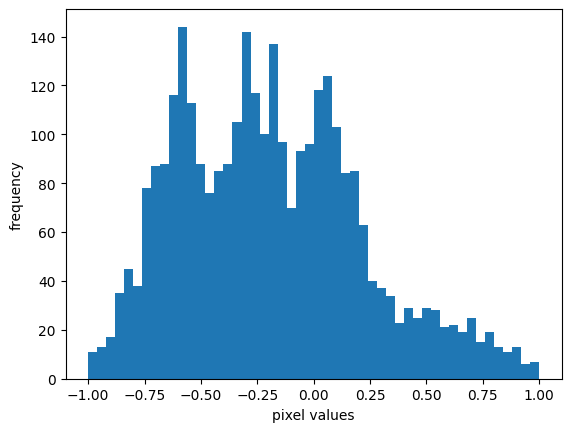

In [7]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [8]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [9]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [10]:
x_train_normalized_np[0][0].shape

(32, 32)

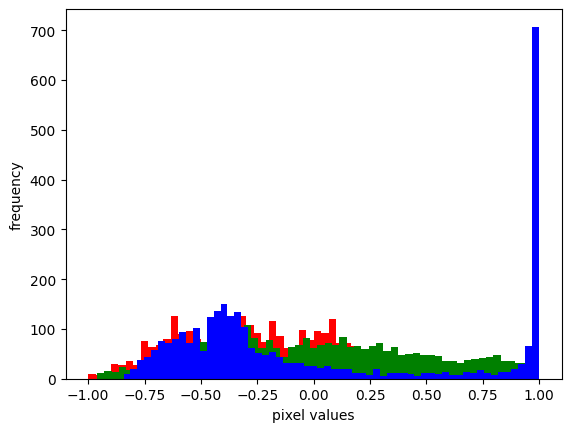

In [11]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [12]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_labels4clients(x_train_normalized_np,y_train,dictionary,False)

In [13]:
def getDist(y,num_classes,user_num):
    ax = sns.countplot(x=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

10000


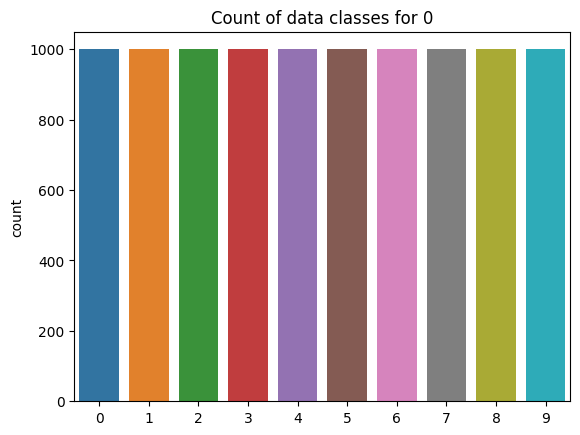

10000


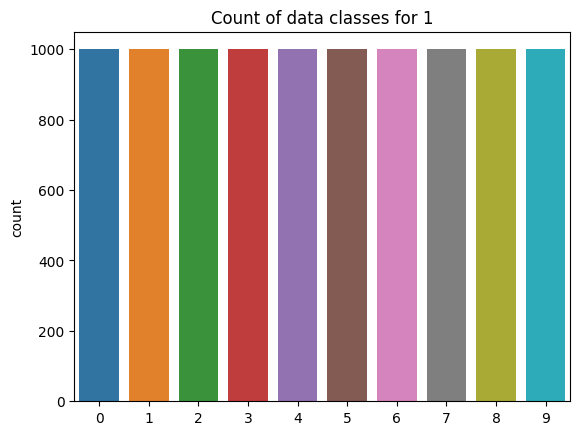

10000


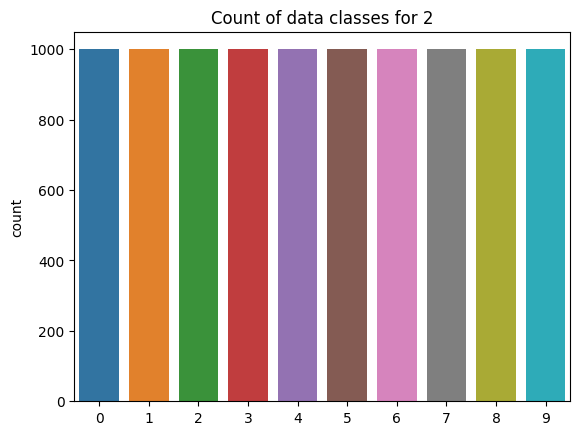

10000


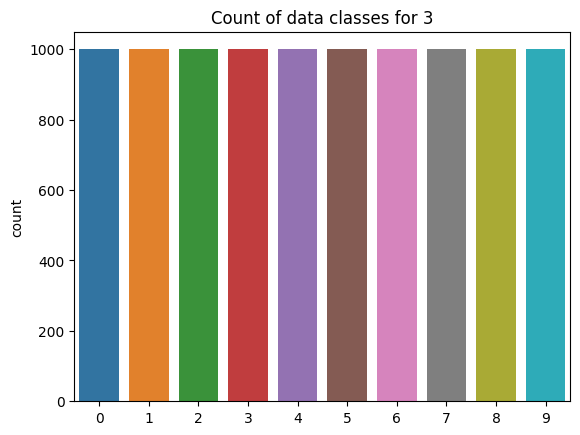

10000


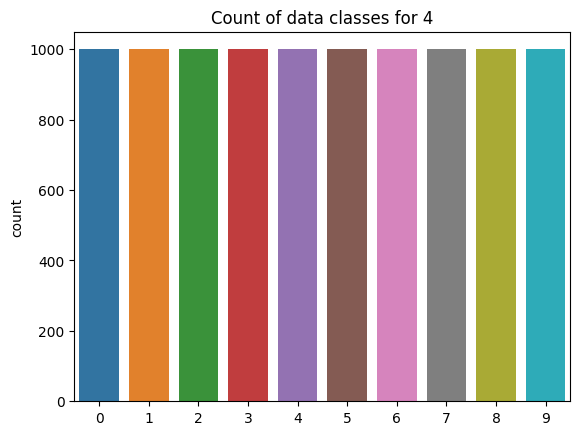

In [14]:
for i in range (len(x_clinet_list)):
    print(len(y_client_list[i]))
    getDist(y_client_list[i],num_classes,i)

In [15]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [16]:
fic_model = InceptionV3().to(dev)

In [17]:
main_server = Server(0,LEARNING_RATE,B1,B2)
main_server.generator.train()
workers = []
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE,B1,B2)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    worker.load_worker_data(x_clinet_list[i], y_client_list[i])
    worker.discriminator.train()
    workers.append(worker)
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [18]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev)

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

In [19]:
trial = False

In [20]:
# GAN archicture trial (trial == TRUE)
if trial:
    start = 0
    end = start + NUM_EPOCHS
    for epoch in range(start,end):
        for i, data in enumerate(dataloader_one):
            worker = workers[0]
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)
            real, _ = data

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
            current_disc_real = worker.discriminator(real).reshape(-1)
            # print('current discriminator real output', current_disc_real)
            worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
            # print('worker loss_disc_real output', current_disc_real)
            current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
            worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            worker.loss_disc.backward()
            # total_norm_d =0
            # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
            #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
            # total_norm_d = total_norm_d ** 0.5

            worker.d_optimizer.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
            output = worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()

            # total_norm_g =0
            # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
            #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
            # total_norm_g = total_norm_g ** 0.5

            main_server.g_optimizer.step()


            logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

            # Print loss
            if i % 100 == 0:    
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,i,len(dataloader_one))

                print(
                    f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
                    Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )

            if i% 500 == 0:
                with torch.no_grad():
                    fake = main_server.generator(fixed_noise)
                    logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
        if epoch % 50 == 0 and epoch !=0:
            logger.save_models(main_server,workers,epoch)


Epoch [0/200] Batch 0/157                     Loss D: 0.6952, loss G: 0.7305, FID Score: 438.4
Epoch [0/200] Batch 100/157                     Loss D: 0.5299, loss G: 1.6425, FID Score: 401.2
Epoch [1/200] Batch 0/157                     Loss D: 0.5043, loss G: 1.7884, FID Score: 510.0
Epoch [1/200] Batch 100/157                     Loss D: 0.8268, loss G: 0.7939, FID Score: 306.4
Epoch [2/200] Batch 0/157                     Loss D: 0.4913, loss G: 1.1915, FID Score: 357.8
Epoch [2/200] Batch 100/157                     Loss D: 0.5256, loss G: 0.8054, FID Score: 370.6
Epoch [3/200] Batch 0/157                     Loss D: 0.5976, loss G: 0.7246, FID Score: 323.7
Epoch [3/200] Batch 100/157                     Loss D: 0.6038, loss G: 0.9056, FID Score: 383.5
Epoch [4/200] Batch 0/157                     Loss D: 0.4788, loss G: 0.9374, FID Score: 307.1
Epoch [4/200] Batch 100/157                     Loss D: 0.3450, loss G: 1.2341, FID Score: 293.1
Epoch [5/200] Batch 0/157               

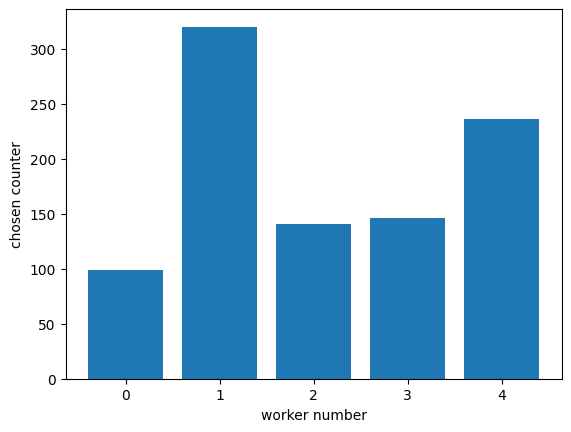

Epoch [6/200] Batch 0/157                     Loss D: 0.7326, loss G: 0.8179, FID Score: 340.4
Epoch [6/200] Batch 100/157                     Loss D: 0.7546, loss G: 0.7368, FID Score: 323.9
Epoch [7/200] Batch 0/157                     Loss D: 0.6039, loss G: 1.0931, FID Score: 374.0
Epoch [7/200] Batch 100/157                     Loss D: 0.7256, loss G: 0.6622, FID Score: 326.3
Epoch [8/200] Batch 0/157                     Loss D: 0.7273, loss G: 1.0379, FID Score: 319.4
Epoch [8/200] Batch 100/157                     Loss D: 0.8558, loss G: 0.6929, FID Score: 305.3
Epoch [9/200] Batch 0/157                     Loss D: 0.7161, loss G: 0.6120, FID Score: 305.2
Epoch [9/200] Batch 100/157                     Loss D: 0.6313, loss G: 0.7333, FID Score: 294.6
Epoch [10/200] Batch 0/157                     Loss D: 0.5731, loss G: 0.8191, FID Score: 303.1
Epoch [10/200] Batch 100/157                     Loss D: 0.6669, loss G: 0.6941, FID Score: 341.4


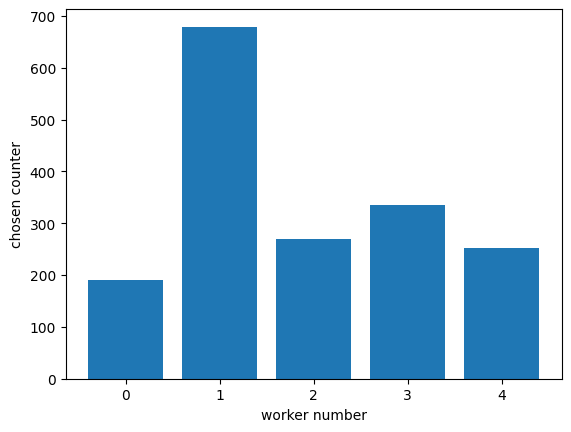

Epoch [11/200] Batch 0/157                     Loss D: 0.6712, loss G: 0.7493, FID Score: 322.4
Epoch [11/200] Batch 100/157                     Loss D: 0.6202, loss G: 0.8569, FID Score: 270.4
Epoch [12/200] Batch 0/157                     Loss D: 0.7812, loss G: 0.7412, FID Score: 321.1
Epoch [12/200] Batch 100/157                     Loss D: 0.6921, loss G: 0.7619, FID Score: 313.0
Epoch [13/200] Batch 0/157                     Loss D: 0.6304, loss G: 0.7615, FID Score: 346.2
Epoch [13/200] Batch 100/157                     Loss D: 0.6663, loss G: 1.2780, FID Score: 280.5
Epoch [14/200] Batch 0/157                     Loss D: 0.5813, loss G: 0.9119, FID Score: 339.3
Epoch [14/200] Batch 100/157                     Loss D: 0.6646, loss G: 0.8584, FID Score: 349.0
Epoch [15/200] Batch 0/157                     Loss D: 0.6409, loss G: 0.6400, FID Score: 334.5
Epoch [15/200] Batch 100/157                     Loss D: 0.8121, loss G: 0.9370, FID Score: 275.9


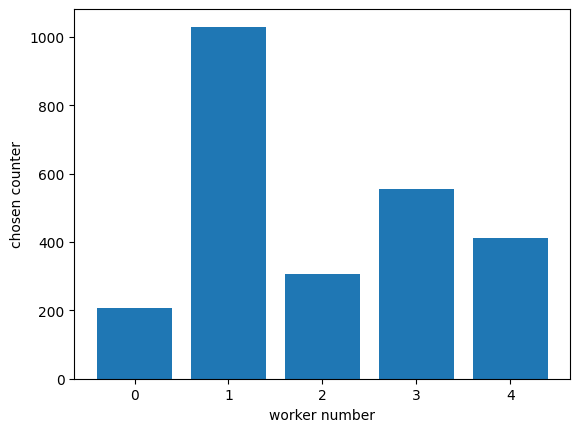

Epoch [16/200] Batch 0/157                     Loss D: 0.6305, loss G: 0.6169, FID Score: 308.8
Epoch [16/200] Batch 100/157                     Loss D: 0.5334, loss G: 0.7009, FID Score: 264.4
Epoch [17/200] Batch 0/157                     Loss D: 0.6984, loss G: 0.8419, FID Score: 352.3
Epoch [17/200] Batch 100/157                     Loss D: 0.6514, loss G: 0.6553, FID Score: 287.4
Epoch [18/200] Batch 0/157                     Loss D: 0.6721, loss G: 0.6191, FID Score: 357.0
Epoch [18/200] Batch 100/157                     Loss D: 0.6147, loss G: 0.7278, FID Score: 299.2
Epoch [19/200] Batch 0/157                     Loss D: 0.5053, loss G: 0.9718, FID Score: 345.9
Epoch [19/200] Batch 100/157                     Loss D: 0.6007, loss G: 0.8715, FID Score: 280.7
Epoch [20/200] Batch 0/157                     Loss D: 0.6373, loss G: 2.7325, FID Score: 271.3
Epoch [20/200] Batch 100/157                     Loss D: 0.4950, loss G: 0.7594, FID Score: 265.9


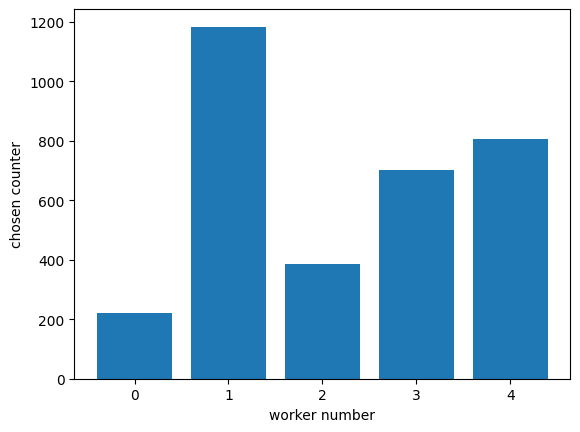

Epoch [21/200] Batch 0/157                     Loss D: 0.5469, loss G: 0.7227, FID Score: 275.7
Epoch [21/200] Batch 100/157                     Loss D: 1.3178, loss G: 0.6970, FID Score: 359.8
Epoch [22/200] Batch 0/157                     Loss D: 0.6780, loss G: 1.0713, FID Score: 295.9
Epoch [22/200] Batch 100/157                     Loss D: 0.9532, loss G: 0.7012, FID Score: 264.3
Epoch [23/200] Batch 0/157                     Loss D: 0.4818, loss G: 2.0183, FID Score: 267.9
Epoch [23/200] Batch 100/157                     Loss D: 0.9570, loss G: 0.9669, FID Score: 282.0
Epoch [24/200] Batch 0/157                     Loss D: 0.5568, loss G: 0.7701, FID Score: 280.9
Epoch [24/200] Batch 100/157                     Loss D: 0.6299, loss G: 0.6964, FID Score: 266.0
Epoch [25/200] Batch 0/157                     Loss D: 0.7264, loss G: 0.6323, FID Score: 278.6
Epoch [25/200] Batch 100/157                     Loss D: 0.7134, loss G: 0.7857, FID Score: 334.9


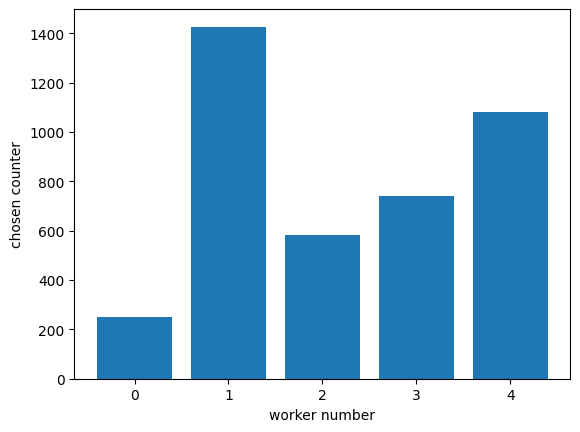

Epoch [26/200] Batch 0/157                     Loss D: 0.7101, loss G: 0.6020, FID Score: 273.8
Epoch [26/200] Batch 100/157                     Loss D: 0.6370, loss G: 0.8187, FID Score: 290.3
Epoch [27/200] Batch 0/157                     Loss D: 0.4535, loss G: 1.3242, FID Score: 301.4
Epoch [27/200] Batch 100/157                     Loss D: 0.5390, loss G: 0.8410, FID Score: 296.0
Epoch [28/200] Batch 0/157                     Loss D: 0.5514, loss G: 0.9142, FID Score: 301.9
Epoch [28/200] Batch 100/157                     Loss D: 0.4891, loss G: 1.5545, FID Score: 259.3
Epoch [29/200] Batch 0/157                     Loss D: 0.6754, loss G: 0.9757, FID Score: 310.7
Epoch [29/200] Batch 100/157                     Loss D: 0.5225, loss G: 1.0319, FID Score: 257.5
Epoch [30/200] Batch 0/157                     Loss D: 0.6849, loss G: 0.7889, FID Score: 297.8
Epoch [30/200] Batch 100/157                     Loss D: 0.5587, loss G: 0.9295, FID Score: 311.7


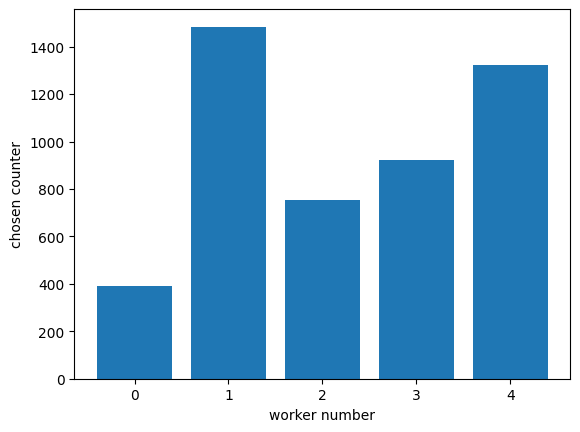

Epoch [31/200] Batch 0/157                     Loss D: 0.5064, loss G: 1.1968, FID Score: 309.7
Epoch [31/200] Batch 100/157                     Loss D: 0.4829, loss G: 0.9162, FID Score: 275.9
Epoch [32/200] Batch 0/157                     Loss D: 0.4661, loss G: 1.1998, FID Score: 285.7
Epoch [32/200] Batch 100/157                     Loss D: 0.3624, loss G: 1.1298, FID Score: 301.9
Epoch [33/200] Batch 0/157                     Loss D: 0.5106, loss G: 1.0026, FID Score: 294.9
Epoch [33/200] Batch 100/157                     Loss D: 0.6365, loss G: 1.2278, FID Score: 294.4
Epoch [34/200] Batch 0/157                     Loss D: 0.5143, loss G: 0.8125, FID Score: 285.7
Epoch [34/200] Batch 100/157                     Loss D: 0.5196, loss G: 0.9298, FID Score: 267.5
Epoch [35/200] Batch 0/157                     Loss D: 0.5825, loss G: 0.6777, FID Score: 268.5
Epoch [35/200] Batch 100/157                     Loss D: 1.4025, loss G: 9.3162, FID Score: 281.7


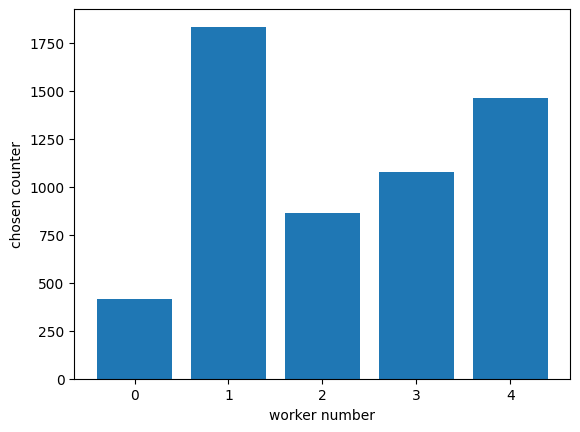

Epoch [36/200] Batch 0/157                     Loss D: 0.4771, loss G: 0.9078, FID Score: 287.3
Epoch [36/200] Batch 100/157                     Loss D: 0.6335, loss G: 0.5674, FID Score: 308.5
Epoch [37/200] Batch 0/157                     Loss D: 0.5512, loss G: 0.7349, FID Score: 281.5
Epoch [37/200] Batch 100/157                     Loss D: 0.4724, loss G: 1.2272, FID Score: 279.2
Epoch [38/200] Batch 0/157                     Loss D: 0.5523, loss G: 0.7186, FID Score: 324.9
Epoch [38/200] Batch 100/157                     Loss D: 0.5284, loss G: 0.8476, FID Score: 285.1
Epoch [39/200] Batch 0/157                     Loss D: 0.5797, loss G: 0.8863, FID Score: 268.6
Epoch [39/200] Batch 100/157                     Loss D: 0.3994, loss G: 1.0420, FID Score: 319.6
Epoch [40/200] Batch 0/157                     Loss D: 0.6635, loss G: 0.9945, FID Score: 278.3
Epoch [40/200] Batch 100/157                     Loss D: 0.3789, loss G: 1.0151, FID Score: 283.7


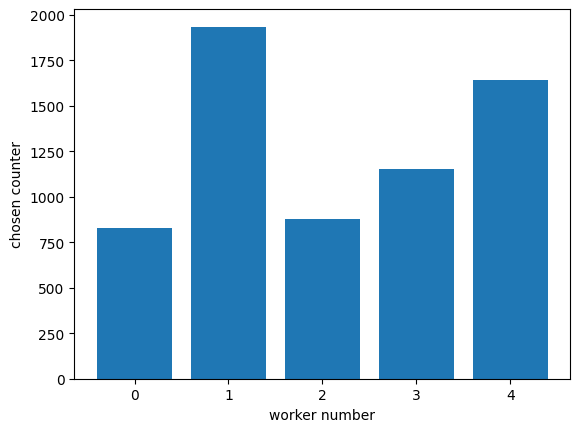

Epoch [41/200] Batch 0/157                     Loss D: 0.3679, loss G: 1.2376, FID Score: 260.9
Epoch [41/200] Batch 100/157                     Loss D: 0.5295, loss G: 0.7995, FID Score: 271.6
Epoch [42/200] Batch 0/157                     Loss D: 0.4567, loss G: 0.7734, FID Score: 289.5
Epoch [42/200] Batch 100/157                     Loss D: 0.5641, loss G: 0.9261, FID Score: 290.8
Epoch [43/200] Batch 0/157                     Loss D: 0.4158, loss G: 1.4658, FID Score: 281.2
Epoch [43/200] Batch 100/157                     Loss D: 0.6810, loss G: 0.8563, FID Score: 279.0
Epoch [44/200] Batch 0/157                     Loss D: 0.6458, loss G: 6.4513, FID Score: 311.0
Epoch [44/200] Batch 100/157                     Loss D: 0.6058, loss G: 0.8448, FID Score: 283.3
Epoch [45/200] Batch 0/157                     Loss D: 0.5833, loss G: 0.7410, FID Score: 259.8
Epoch [45/200] Batch 100/157                     Loss D: 0.6797, loss G: 0.7417, FID Score: 292.4


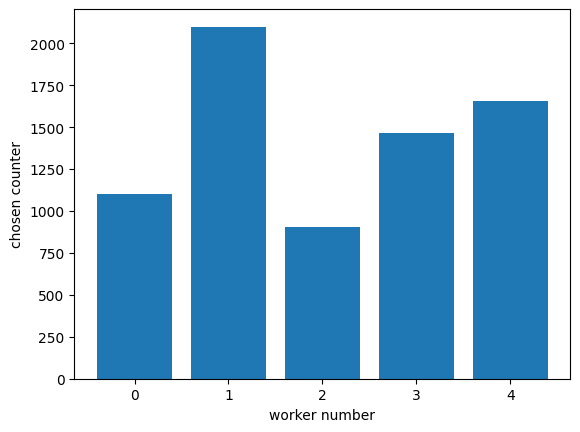

Epoch [46/200] Batch 0/157                     Loss D: 0.6406, loss G: 0.6841, FID Score: 282.3
Epoch [46/200] Batch 100/157                     Loss D: 0.6021, loss G: 0.7933, FID Score: 296.9
Epoch [47/200] Batch 0/157                     Loss D: 0.4874, loss G: 1.1158, FID Score: 277.2
Epoch [47/200] Batch 100/157                     Loss D: 0.5886, loss G: 0.6350, FID Score: 285.7
Epoch [48/200] Batch 0/157                     Loss D: 0.6249, loss G: 0.6357, FID Score: 292.3
Epoch [48/200] Batch 100/157                     Loss D: 0.5598, loss G: 0.7619, FID Score: 261.3
Epoch [49/200] Batch 0/157                     Loss D: 0.6574, loss G: 0.6131, FID Score: 301.7
Epoch [49/200] Batch 100/157                     Loss D: 0.6023, loss G: 0.9095, FID Score: 287.0
Epoch [50/200] Batch 0/157                     Loss D: 0.4985, loss G: 0.8200, FID Score: 262.0
Epoch [50/200] Batch 100/157                     Loss D: 0.5626, loss G: 0.6703, FID Score: 271.6


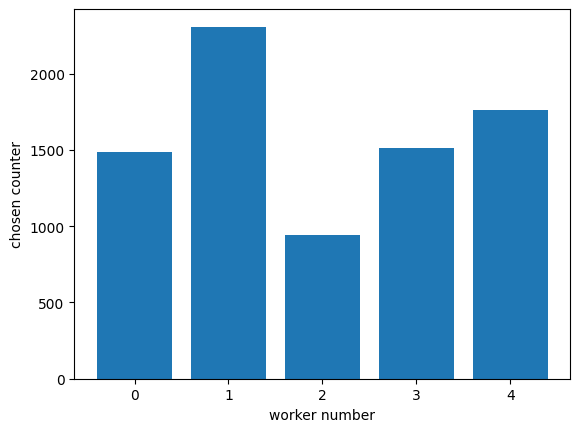

Epoch [51/200] Batch 0/157                     Loss D: 0.5876, loss G: 0.7042, FID Score: 296.1
Epoch [51/200] Batch 100/157                     Loss D: 0.9881, loss G: 0.6610, FID Score: 256.8
Epoch [52/200] Batch 0/157                     Loss D: 0.6089, loss G: 0.7141, FID Score: 268.0
Epoch [52/200] Batch 100/157                     Loss D: 0.6608, loss G: 0.6846, FID Score: 294.9
Epoch [53/200] Batch 0/157                     Loss D: 0.6624, loss G: 0.5764, FID Score: 305.5
Epoch [53/200] Batch 100/157                     Loss D: 0.5793, loss G: 0.7748, FID Score: 251.5
Epoch [54/200] Batch 0/157                     Loss D: 0.5739, loss G: 0.6031, FID Score: 299.1
Epoch [54/200] Batch 100/157                     Loss D: 0.6123, loss G: 0.6527, FID Score: 277.2
Epoch [55/200] Batch 0/157                     Loss D: 0.5933, loss G: 0.7065, FID Score: 281.1
Epoch [55/200] Batch 100/157                     Loss D: 0.5820, loss G: 0.7625, FID Score: 263.2


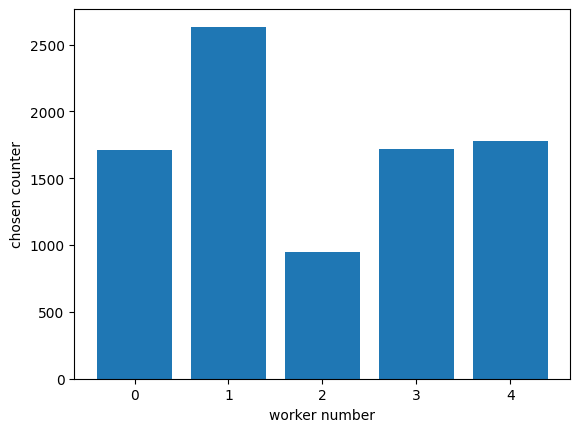

Epoch [56/200] Batch 0/157                     Loss D: 0.5765, loss G: 1.0555, FID Score: 271.4
Epoch [56/200] Batch 100/157                     Loss D: 1.0957, loss G: 0.9054, FID Score: 305.7
Epoch [57/200] Batch 0/157                     Loss D: 0.5753, loss G: 1.0844, FID Score: 302.7
Epoch [57/200] Batch 100/157                     Loss D: 0.5978, loss G: 0.6616, FID Score: 258.4
Epoch [58/200] Batch 0/157                     Loss D: 0.6062, loss G: 0.8507, FID Score: 282.3
Epoch [58/200] Batch 100/157                     Loss D: 0.5976, loss G: 1.0039, FID Score: 325.1
Epoch [59/200] Batch 0/157                     Loss D: 0.5197, loss G: 0.8252, FID Score: 285.1
Epoch [59/200] Batch 100/157                     Loss D: 0.5997, loss G: 0.7691, FID Score: 251.3
Epoch [60/200] Batch 0/157                     Loss D: 0.5773, loss G: 0.6559, FID Score: 273.4
Epoch [60/200] Batch 100/157                     Loss D: 0.5211, loss G: 0.8542, FID Score: 254.1


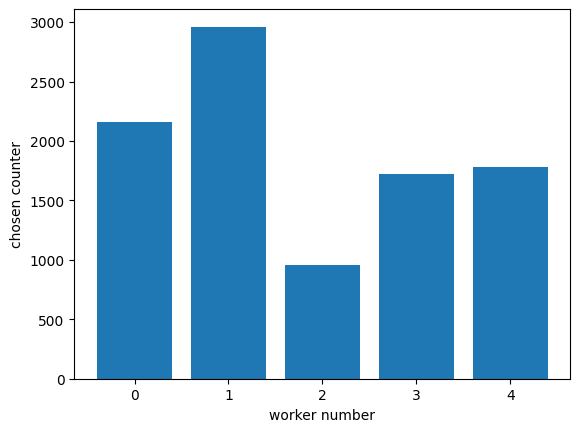

Epoch [61/200] Batch 0/157                     Loss D: 0.6041, loss G: 0.9366, FID Score: 263.0
Epoch [61/200] Batch 100/157                     Loss D: 0.5618, loss G: 0.7259, FID Score: 264.6
Epoch [62/200] Batch 0/157                     Loss D: 0.6234, loss G: 0.8596, FID Score: 269.7
Epoch [62/200] Batch 100/157                     Loss D: 0.4598, loss G: 0.9043, FID Score: 263.8
Epoch [63/200] Batch 0/157                     Loss D: 0.7044, loss G: 0.6304, FID Score: 256.3
Epoch [63/200] Batch 100/157                     Loss D: 1.0492, loss G: 1.5570, FID Score: 283.7
Epoch [64/200] Batch 0/157                     Loss D: 0.5560, loss G: 0.8434, FID Score: 271.5
Epoch [64/200] Batch 100/157                     Loss D: 0.5567, loss G: 0.8053, FID Score: 268.9
Epoch [65/200] Batch 0/157                     Loss D: 0.5478, loss G: 0.6885, FID Score: 284.6
Epoch [65/200] Batch 100/157                     Loss D: 0.4008, loss G: 1.0368, FID Score: 266.3


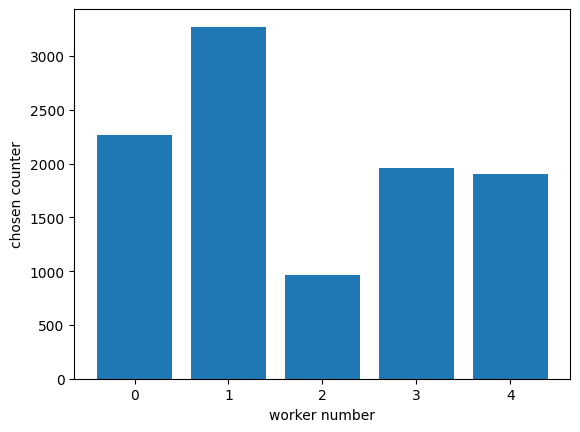

Epoch [66/200] Batch 0/157                     Loss D: 0.5648, loss G: 1.0045, FID Score: 273.1
Epoch [66/200] Batch 100/157                     Loss D: 0.6411, loss G: 0.6937, FID Score: 267.4
Epoch [67/200] Batch 0/157                     Loss D: 0.5116, loss G: 1.0705, FID Score: 270.6
Epoch [67/200] Batch 100/157                     Loss D: 0.5227, loss G: 1.0213, FID Score: 255.8
Epoch [68/200] Batch 0/157                     Loss D: 0.6518, loss G: 0.5533, FID Score: 282.3
Epoch [68/200] Batch 100/157                     Loss D: 0.5003, loss G: 0.7817, FID Score: 270.2
Epoch [69/200] Batch 0/157                     Loss D: 0.5951, loss G: 0.6828, FID Score: 285.8
Epoch [69/200] Batch 100/157                     Loss D: 0.4160, loss G: 0.9603, FID Score: 268.3
Epoch [70/200] Batch 0/157                     Loss D: 0.4764, loss G: 1.1012, FID Score: 299.3
Epoch [70/200] Batch 100/157                     Loss D: 0.4698, loss G: 1.2527, FID Score: 279.9


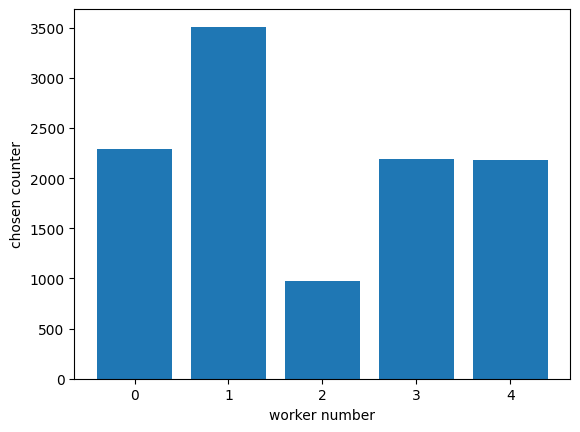

Epoch [71/200] Batch 0/157                     Loss D: 0.6506, loss G: 1.1232, FID Score: 282.3
Epoch [71/200] Batch 100/157                     Loss D: 0.6675, loss G: 0.6653, FID Score: 274.3
Epoch [72/200] Batch 0/157                     Loss D: 0.5262, loss G: 0.6347, FID Score: 288.7
Epoch [72/200] Batch 100/157                     Loss D: 0.6921, loss G: 0.5581, FID Score: 284.0
Epoch [73/200] Batch 0/157                     Loss D: 0.6613, loss G: 0.7156, FID Score: 280.8
Epoch [73/200] Batch 100/157                     Loss D: 0.4832, loss G: 0.8808, FID Score: 281.8
Epoch [74/200] Batch 0/157                     Loss D: 0.4401, loss G: 0.9830, FID Score: 294.1
Epoch [74/200] Batch 100/157                     Loss D: 0.6764, loss G: 0.5802, FID Score: 272.6
Epoch [75/200] Batch 0/157                     Loss D: 0.7533, loss G: 0.5749, FID Score: 312.1
Epoch [75/200] Batch 100/157                     Loss D: 0.4718, loss G: 0.8069, FID Score: 285.4


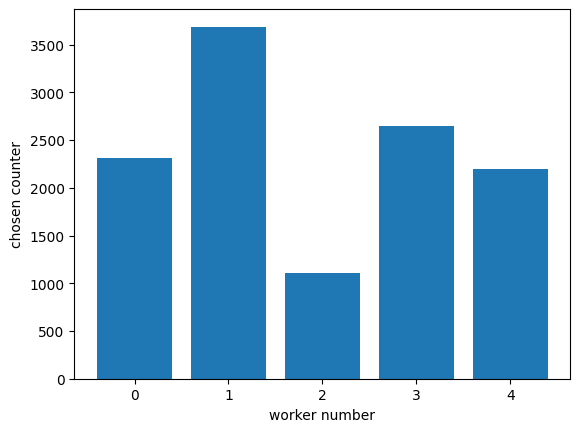

Epoch [76/200] Batch 0/157                     Loss D: 0.6387, loss G: 0.6251, FID Score: 278.2
Epoch [76/200] Batch 100/157                     Loss D: 0.6694, loss G: 0.6664, FID Score: 265.0
Epoch [77/200] Batch 0/157                     Loss D: 0.5396, loss G: 0.7577, FID Score: 275.4
Epoch [77/200] Batch 100/157                     Loss D: 0.5656, loss G: 0.7682, FID Score: 268.9
Epoch [78/200] Batch 0/157                     Loss D: 0.4949, loss G: 0.8615, FID Score: 273.1
Epoch [78/200] Batch 100/157                     Loss D: 0.5527, loss G: 0.6269, FID Score: 279.6
Epoch [79/200] Batch 0/157                     Loss D: 0.6302, loss G: 0.6493, FID Score: 302.8
Epoch [79/200] Batch 100/157                     Loss D: 0.6612, loss G: 0.7597, FID Score: 279.7
Epoch [80/200] Batch 0/157                     Loss D: 0.5968, loss G: 0.7438, FID Score: 257.6
Epoch [80/200] Batch 100/157                     Loss D: 0.4927, loss G: 1.0092, FID Score: 270.5


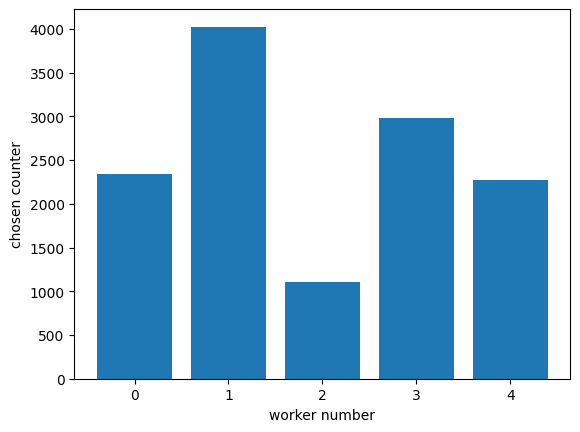

Epoch [81/200] Batch 0/157                     Loss D: 0.5452, loss G: 0.8075, FID Score: 263.1
Epoch [81/200] Batch 100/157                     Loss D: 0.6050, loss G: 0.6933, FID Score: 275.8
Epoch [82/200] Batch 0/157                     Loss D: 0.5773, loss G: 0.7363, FID Score: 270.0
Epoch [82/200] Batch 100/157                     Loss D: 0.5811, loss G: 0.7230, FID Score: 268.0
Epoch [83/200] Batch 0/157                     Loss D: 0.5714, loss G: 0.8267, FID Score: 298.7
Epoch [83/200] Batch 100/157                     Loss D: 0.5330, loss G: 0.8714, FID Score: 254.6
Epoch [84/200] Batch 0/157                     Loss D: 0.5762, loss G: 0.6842, FID Score: 290.8
Epoch [84/200] Batch 100/157                     Loss D: 0.5457, loss G: 0.8189, FID Score: 270.2
Epoch [85/200] Batch 0/157                     Loss D: 0.6537, loss G: 0.5744, FID Score: 267.6
Epoch [85/200] Batch 100/157                     Loss D: 0.6471, loss G: 0.7043, FID Score: 265.7


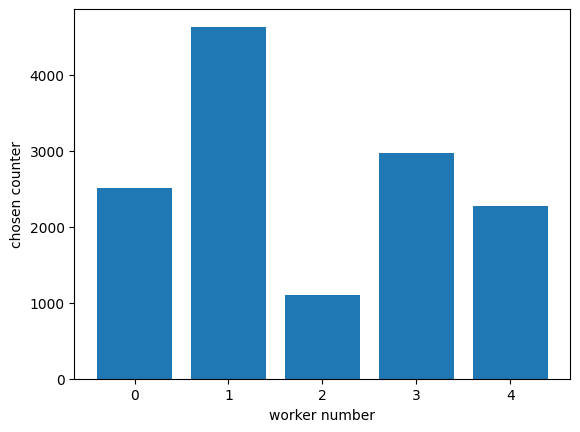

Epoch [86/200] Batch 0/157                     Loss D: 0.6516, loss G: 0.6635, FID Score: 292.0
Epoch [86/200] Batch 100/157                     Loss D: 0.6403, loss G: 3.8168, FID Score: 283.2
Epoch [87/200] Batch 0/157                     Loss D: 0.6441, loss G: 0.6443, FID Score: 277.8
Epoch [87/200] Batch 100/157                     Loss D: 0.6875, loss G: 0.5327, FID Score: 264.6
Epoch [88/200] Batch 0/157                     Loss D: 0.7125, loss G: 0.5718, FID Score: 276.5
Epoch [88/200] Batch 100/157                     Loss D: 0.6123, loss G: 0.6093, FID Score: 313.6
Epoch [89/200] Batch 0/157                     Loss D: 0.6998, loss G: 0.5758, FID Score: 271.5
Epoch [89/200] Batch 100/157                     Loss D: 0.5417, loss G: 0.8392, FID Score: 297.0
Epoch [90/200] Batch 0/157                     Loss D: 0.5869, loss G: 0.9029, FID Score: 277.0
Epoch [90/200] Batch 100/157                     Loss D: 0.6029, loss G: 0.7351, FID Score: 273.4


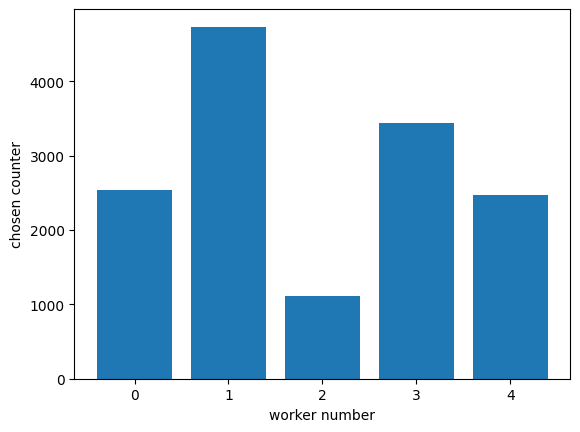

Epoch [91/200] Batch 0/157                     Loss D: 0.4845, loss G: 1.0352, FID Score: 298.3
Epoch [91/200] Batch 100/157                     Loss D: 0.8150, loss G: 0.6864, FID Score: 263.3
Epoch [92/200] Batch 0/157                     Loss D: 0.5467, loss G: 0.6942, FID Score: 313.1
Epoch [92/200] Batch 100/157                     Loss D: 0.6246, loss G: 0.5955, FID Score: 260.8
Epoch [93/200] Batch 0/157                     Loss D: 0.6137, loss G: 0.7095, FID Score: 267.2
Epoch [93/200] Batch 100/157                     Loss D: 0.7029, loss G: 0.6671, FID Score: 284.7
Epoch [94/200] Batch 0/157                     Loss D: 0.5668, loss G: 0.5998, FID Score: 268.6
Epoch [94/200] Batch 100/157                     Loss D: 0.5761, loss G: 0.7917, FID Score: 284.5
Epoch [95/200] Batch 0/157                     Loss D: 0.6301, loss G: 0.6002, FID Score: 258.5
Epoch [95/200] Batch 100/157                     Loss D: 0.6177, loss G: 0.8664, FID Score: 269.5


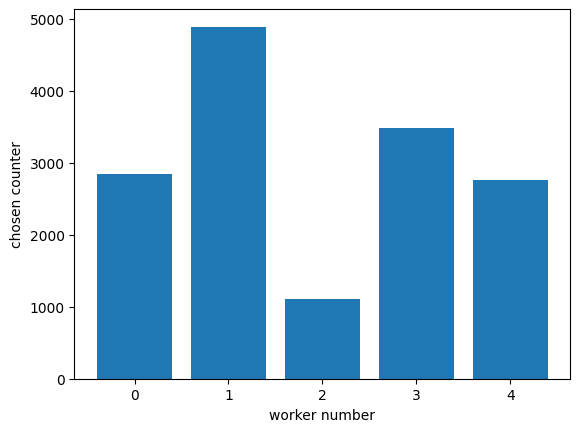

Epoch [96/200] Batch 0/157                     Loss D: 0.6184, loss G: 0.9269, FID Score: 284.1
Epoch [96/200] Batch 100/157                     Loss D: 0.6112, loss G: 0.6460, FID Score: 267.3
Epoch [97/200] Batch 0/157                     Loss D: 0.5500, loss G: 0.8691, FID Score: 248.8
Epoch [97/200] Batch 100/157                     Loss D: 0.6324, loss G: 0.5998, FID Score: 272.0
Epoch [98/200] Batch 0/157                     Loss D: 0.5956, loss G: 0.6290, FID Score: 259.4
Epoch [98/200] Batch 100/157                     Loss D: 0.6729, loss G: 0.7351, FID Score: 268.2
Epoch [99/200] Batch 0/157                     Loss D: 0.6780, loss G: 0.5712, FID Score: 260.6
Epoch [99/200] Batch 100/157                     Loss D: 0.6614, loss G: 0.6651, FID Score: 254.3
Epoch [100/200] Batch 0/157                     Loss D: 0.6694, loss G: 0.5594, FID Score: 274.8
Epoch [100/200] Batch 100/157                     Loss D: 0.6297, loss G: 0.7662, FID Score: 255.7


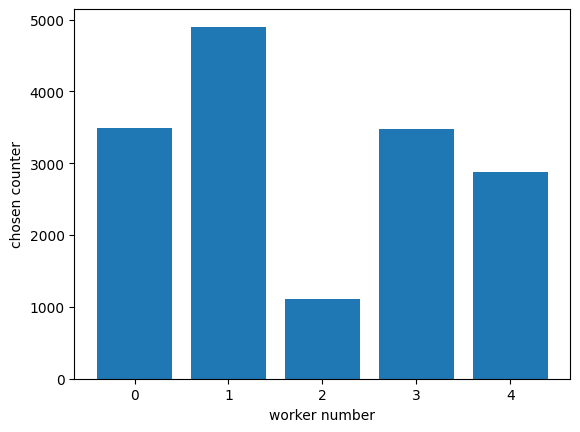

Epoch [101/200] Batch 0/157                     Loss D: 0.6142, loss G: 0.6980, FID Score: 268.5
Epoch [101/200] Batch 100/157                     Loss D: 0.6574, loss G: 0.7697, FID Score: 258.7
Epoch [102/200] Batch 0/157                     Loss D: 0.5837, loss G: 0.6827, FID Score: 357.9
Epoch [102/200] Batch 100/157                     Loss D: 0.7454, loss G: 0.5507, FID Score: 300.3
Epoch [103/200] Batch 0/157                     Loss D: 0.5475, loss G: 0.8320, FID Score: 291.8
Epoch [103/200] Batch 100/157                     Loss D: 0.6873, loss G: 0.7707, FID Score: 287.6
Epoch [104/200] Batch 0/157                     Loss D: 0.5094, loss G: 1.1274, FID Score: 283.7
Epoch [104/200] Batch 100/157                     Loss D: 0.6337, loss G: 0.6962, FID Score: 284.3
Epoch [105/200] Batch 0/157                     Loss D: 0.6514, loss G: 0.5920, FID Score: 266.4
Epoch [105/200] Batch 100/157                     Loss D: 0.5469, loss G: 0.7125, FID Score: 258.4


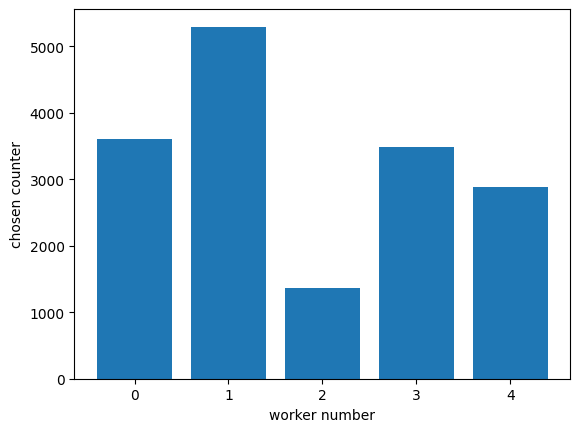

Epoch [106/200] Batch 0/157                     Loss D: 0.6081, loss G: 0.7565, FID Score: 250.5
Epoch [106/200] Batch 100/157                     Loss D: 0.5294, loss G: 0.8211, FID Score: 255.5
Epoch [107/200] Batch 0/157                     Loss D: 0.5891, loss G: 0.7905, FID Score: 258.0
Epoch [107/200] Batch 100/157                     Loss D: 0.9758, loss G: 5.7467, FID Score: 271.9
Epoch [108/200] Batch 0/157                     Loss D: 0.7336, loss G: 0.5543, FID Score: 271.0
Epoch [108/200] Batch 100/157                     Loss D: 0.6516, loss G: 0.5920, FID Score: 256.6
Epoch [109/200] Batch 0/157                     Loss D: 0.6502, loss G: 0.6404, FID Score: 259.5
Epoch [109/200] Batch 100/157                     Loss D: 0.6554, loss G: 0.5389, FID Score: 254.4
Epoch [110/200] Batch 0/157                     Loss D: 1.4810, loss G: 2.7053, FID Score: 290.6
Epoch [110/200] Batch 100/157                     Loss D: 0.6453, loss G: 0.6138, FID Score: 287.1


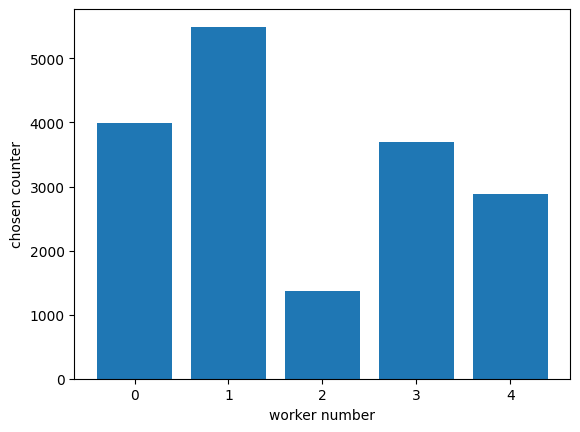

Epoch [111/200] Batch 0/157                     Loss D: 0.6793, loss G: 0.6848, FID Score: 276.6
Epoch [111/200] Batch 100/157                     Loss D: 0.6231, loss G: 0.8549, FID Score: 271.0
Epoch [112/200] Batch 0/157                     Loss D: 0.5825, loss G: 0.6890, FID Score: 276.1
Epoch [112/200] Batch 100/157                     Loss D: 0.6611, loss G: 0.6308, FID Score: 265.2
Epoch [113/200] Batch 0/157                     Loss D: 0.7451, loss G: 0.6311, FID Score: 297.9
Epoch [113/200] Batch 100/157                     Loss D: 0.6225, loss G: 0.6257, FID Score: 264.2
Epoch [114/200] Batch 0/157                     Loss D: 0.6279, loss G: 0.6030, FID Score: 277.5
Epoch [114/200] Batch 100/157                     Loss D: 0.5080, loss G: 0.7732, FID Score: 272.6
Epoch [115/200] Batch 0/157                     Loss D: 1.2593, loss G: 1.9344, FID Score: 282.8
Epoch [115/200] Batch 100/157                     Loss D: 0.4962, loss G: 0.9114, FID Score: 292.5


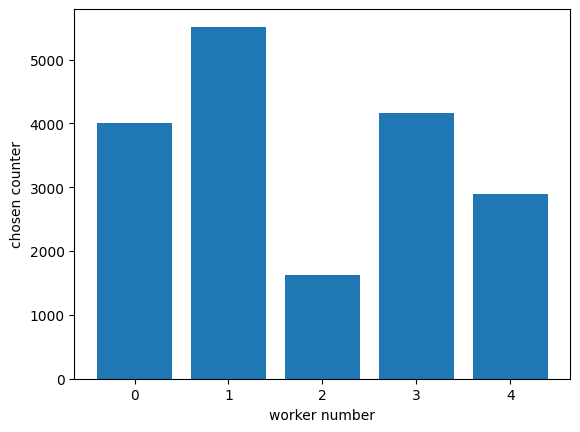

Epoch [116/200] Batch 0/157                     Loss D: 0.6022, loss G: 0.6571, FID Score: 267.4
Epoch [116/200] Batch 100/157                     Loss D: 0.6182, loss G: 0.5616, FID Score: 279.1
Epoch [117/200] Batch 0/157                     Loss D: 1.5330, loss G: 0.3006, FID Score: 290.3
Epoch [117/200] Batch 100/157                     Loss D: 0.7077, loss G: 0.5977, FID Score: 270.2
Epoch [118/200] Batch 0/157                     Loss D: 0.6254, loss G: 0.7127, FID Score: 279.2
Epoch [118/200] Batch 100/157                     Loss D: 0.6263, loss G: 0.8552, FID Score: 299.1
Epoch [119/200] Batch 0/157                     Loss D: 0.6020, loss G: 0.7535, FID Score: 287.6
Epoch [119/200] Batch 100/157                     Loss D: 0.5961, loss G: 0.6283, FID Score: 291.5
Epoch [120/200] Batch 0/157                     Loss D: 0.7190, loss G: 0.6064, FID Score: 274.7
Epoch [120/200] Batch 100/157                     Loss D: 0.6574, loss G: 0.7088, FID Score: 263.9


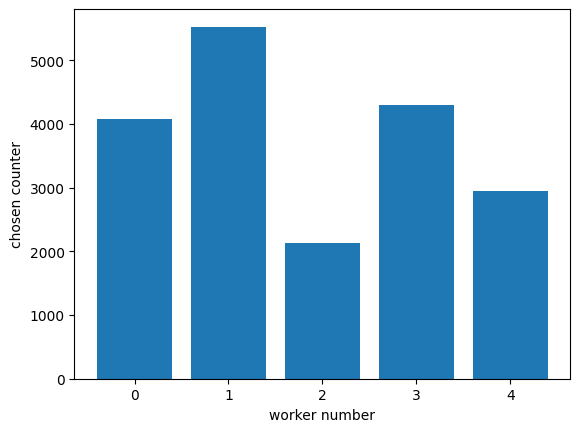

Epoch [121/200] Batch 0/157                     Loss D: 0.5608, loss G: 0.7566, FID Score: 283.6
Epoch [121/200] Batch 100/157                     Loss D: 0.6820, loss G: 0.5356, FID Score: 281.8
Epoch [122/200] Batch 0/157                     Loss D: 0.6132, loss G: 0.5625, FID Score: 268.3
Epoch [122/200] Batch 100/157                     Loss D: 0.6841, loss G: 0.6234, FID Score: 276.8
Epoch [123/200] Batch 0/157                     Loss D: 0.5869, loss G: 0.6299, FID Score: 261.2
Epoch [123/200] Batch 100/157                     Loss D: 0.5560, loss G: 0.8026, FID Score: 253.9
Epoch [124/200] Batch 0/157                     Loss D: 0.6235, loss G: 0.5503, FID Score: 251.1
Epoch [124/200] Batch 100/157                     Loss D: 0.5716, loss G: 1.0060, FID Score: 273.5
Epoch [125/200] Batch 0/157                     Loss D: 0.5525, loss G: 0.8558, FID Score: 268.3
Epoch [125/200] Batch 100/157                     Loss D: 0.5538, loss G: 0.8438, FID Score: 272.9


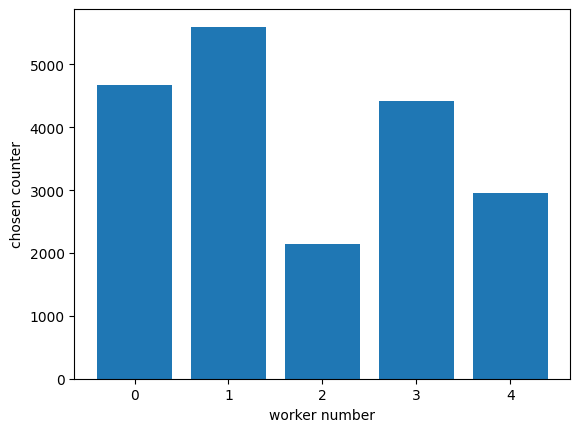

Epoch [126/200] Batch 0/157                     Loss D: 0.5528, loss G: 0.7472, FID Score: 259.1
Epoch [126/200] Batch 100/157                     Loss D: 0.6832, loss G: 0.6120, FID Score: 269.7
Epoch [127/200] Batch 0/157                     Loss D: 1.4862, loss G: 1.6935, FID Score: 257.2
Epoch [127/200] Batch 100/157                     Loss D: 0.7582, loss G: 0.5474, FID Score: 269.1
Epoch [128/200] Batch 0/157                     Loss D: 0.6808, loss G: 0.7113, FID Score: 264.1
Epoch [128/200] Batch 100/157                     Loss D: 0.7855, loss G: 0.6074, FID Score: 280.7
Epoch [129/200] Batch 0/157                     Loss D: 0.6248, loss G: 0.7749, FID Score: 257.4
Epoch [129/200] Batch 100/157                     Loss D: 0.6566, loss G: 0.5748, FID Score: 277.0
Epoch [130/200] Batch 0/157                     Loss D: 0.5881, loss G: 0.9283, FID Score: 278.6
Epoch [130/200] Batch 100/157                     Loss D: 0.6439, loss G: 0.7604, FID Score: 295.1


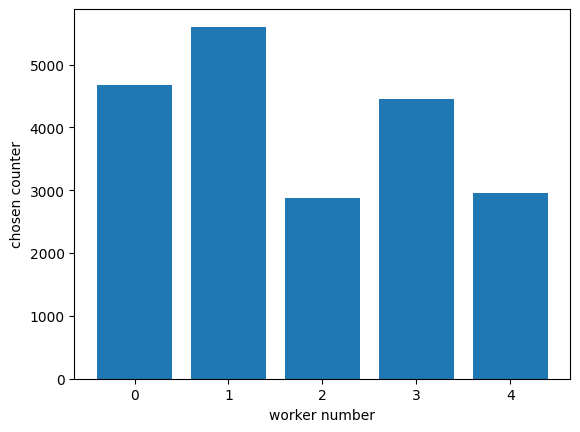

Epoch [131/200] Batch 0/157                     Loss D: 0.6764, loss G: 0.6277, FID Score: 279.5
Epoch [131/200] Batch 100/157                     Loss D: 0.6232, loss G: 0.6569, FID Score: 267.8
Epoch [132/200] Batch 0/157                     Loss D: 0.6302, loss G: 0.6160, FID Score: 270.4
Epoch [132/200] Batch 100/157                     Loss D: 0.6536, loss G: 0.6078, FID Score: 261.4
Epoch [133/200] Batch 0/157                     Loss D: 0.6454, loss G: 0.6401, FID Score: 266.9
Epoch [133/200] Batch 100/157                     Loss D: 0.6084, loss G: 0.6399, FID Score: 259.4
Epoch [134/200] Batch 0/157                     Loss D: 0.5521, loss G: 0.7581, FID Score: 283.0
Epoch [134/200] Batch 100/157                     Loss D: 0.4806, loss G: 0.8144, FID Score: 259.2
Epoch [135/200] Batch 0/157                     Loss D: 0.5240, loss G: 0.7270, FID Score: 262.1
Epoch [135/200] Batch 100/157                     Loss D: 0.6187, loss G: 0.6109, FID Score: 270.6


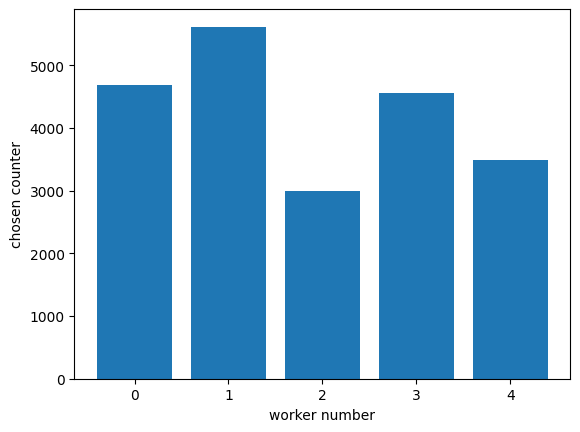

Epoch [136/200] Batch 0/157                     Loss D: 0.6085, loss G: 0.6714, FID Score: 260.8
Epoch [136/200] Batch 100/157                     Loss D: 0.6060, loss G: 0.6027, FID Score: 284.3
Epoch [137/200] Batch 0/157                     Loss D: 0.6173, loss G: 0.7967, FID Score: 264.6
Epoch [137/200] Batch 100/157                     Loss D: 0.6278, loss G: 0.6289, FID Score: 264.2
Epoch [138/200] Batch 0/157                     Loss D: 0.6629, loss G: 0.7881, FID Score: 283.5
Epoch [138/200] Batch 100/157                     Loss D: 0.5249, loss G: 1.0383, FID Score: 264.5
Epoch [139/200] Batch 0/157                     Loss D: 0.6010, loss G: 0.6930, FID Score: 256.4
Epoch [139/200] Batch 100/157                     Loss D: 0.6186, loss G: 0.6009, FID Score: 267.4
Epoch [140/200] Batch 0/157                     Loss D: 0.6481, loss G: 0.6525, FID Score: 268.5
Epoch [140/200] Batch 100/157                     Loss D: 0.6044, loss G: 0.6649, FID Score: 285.6


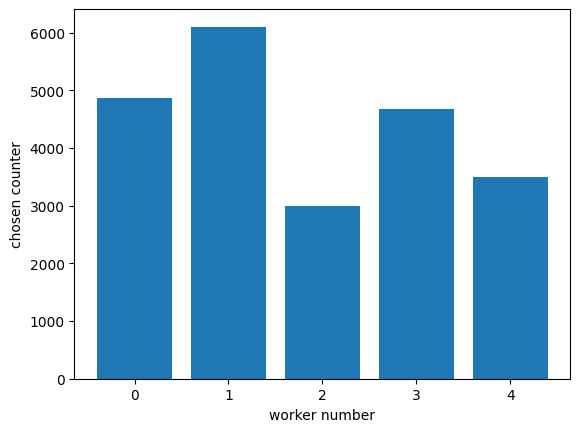

Epoch [141/200] Batch 0/157                     Loss D: 0.5897, loss G: 0.7426, FID Score: 253.3
Epoch [141/200] Batch 100/157                     Loss D: 0.6371, loss G: 0.7700, FID Score: 268.0
Epoch [142/200] Batch 0/157                     Loss D: 0.6737, loss G: 0.5740, FID Score: 272.5
Epoch [142/200] Batch 100/157                     Loss D: 0.6268, loss G: 0.6068, FID Score: 286.9
Epoch [143/200] Batch 0/157                     Loss D: 0.6115, loss G: 0.5790, FID Score: 295.2
Epoch [143/200] Batch 100/157                     Loss D: 0.7022, loss G: 0.5681, FID Score: 261.9
Epoch [144/200] Batch 0/157                     Loss D: 0.6771, loss G: 0.6189, FID Score: 251.0
Epoch [144/200] Batch 100/157                     Loss D: 0.6419, loss G: 0.6546, FID Score: 249.6
Epoch [145/200] Batch 0/157                     Loss D: 0.6724, loss G: 0.5789, FID Score: 274.8
Epoch [145/200] Batch 100/157                     Loss D: 0.6355, loss G: 0.7123, FID Score: 257.7


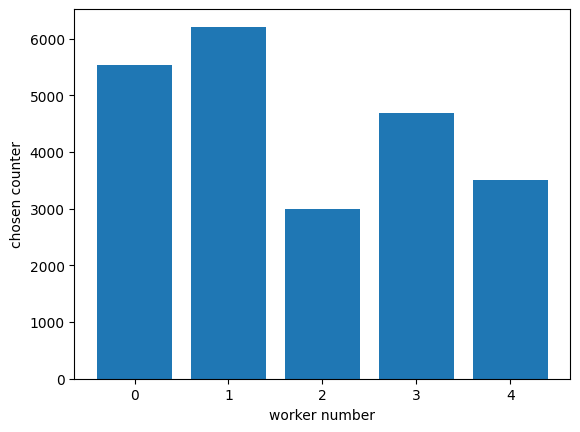

Epoch [146/200] Batch 0/157                     Loss D: 0.7710, loss G: 0.6955, FID Score: 339.5
Epoch [146/200] Batch 100/157                     Loss D: 0.5846, loss G: 0.6924, FID Score: 273.5
Epoch [147/200] Batch 0/157                     Loss D: 0.5865, loss G: 0.6653, FID Score: 251.1
Epoch [147/200] Batch 100/157                     Loss D: 0.6682, loss G: 0.5795, FID Score: 257.7
Epoch [148/200] Batch 0/157                     Loss D: 0.6934, loss G: 3.4478, FID Score: 264.1
Epoch [148/200] Batch 100/157                     Loss D: 0.6112, loss G: 0.8284, FID Score: 242.2
Epoch [149/200] Batch 0/157                     Loss D: 0.6513, loss G: 0.6420, FID Score: 248.7
Epoch [149/200] Batch 100/157                     Loss D: 0.6437, loss G: 0.6684, FID Score: 256.7
Epoch [150/200] Batch 0/157                     Loss D: 0.6374, loss G: 0.5518, FID Score: 253.4
Epoch [150/200] Batch 100/157                     Loss D: 0.6469, loss G: 0.6156, FID Score: 267.2


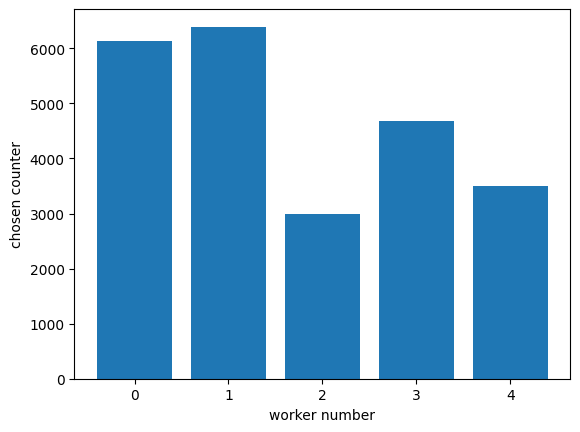

Epoch [151/200] Batch 0/157                     Loss D: 0.6236, loss G: 0.5739, FID Score: 265.3
Epoch [151/200] Batch 100/157                     Loss D: 0.6403, loss G: 0.6899, FID Score: 266.8
Epoch [152/200] Batch 0/157                     Loss D: 0.7740, loss G: 0.6452, FID Score: 312.6
Epoch [152/200] Batch 100/157                     Loss D: 0.6314, loss G: 0.6987, FID Score: 278.2
Epoch [153/200] Batch 0/157                     Loss D: 0.6469, loss G: 0.6510, FID Score: 248.0
Epoch [153/200] Batch 100/157                     Loss D: 0.6522, loss G: 0.6003, FID Score: 255.4
Epoch [154/200] Batch 0/157                     Loss D: 0.5840, loss G: 0.7342, FID Score: 316.4
Epoch [154/200] Batch 100/157                     Loss D: 0.7418, loss G: 0.6805, FID Score: 330.8
Epoch [155/200] Batch 0/157                     Loss D: 0.5638, loss G: 0.7379, FID Score: 245.4
Epoch [155/200] Batch 100/157                     Loss D: 0.6194, loss G: 0.7155, FID Score: 261.8


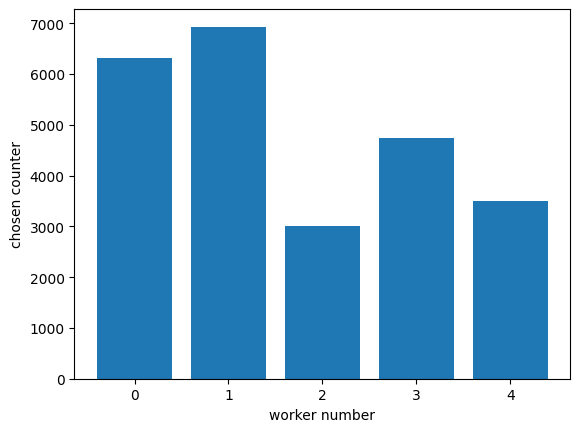

Epoch [156/200] Batch 0/157                     Loss D: 0.6911, loss G: 0.6194, FID Score: 272.6
Epoch [156/200] Batch 100/157                     Loss D: 0.6115, loss G: 0.7422, FID Score: 276.8
Epoch [157/200] Batch 0/157                     Loss D: 0.6436, loss G: 0.6469, FID Score: 253.7
Epoch [157/200] Batch 100/157                     Loss D: 0.5952, loss G: 0.7086, FID Score: 256.1
Epoch [158/200] Batch 0/157                     Loss D: 0.6654, loss G: 0.5822, FID Score: 262.8
Epoch [158/200] Batch 100/157                     Loss D: 0.6515, loss G: 0.6263, FID Score: 266.7
Epoch [159/200] Batch 0/157                     Loss D: 0.6554, loss G: 0.6088, FID Score: 276.4
Epoch [159/200] Batch 100/157                     Loss D: 0.6459, loss G: 0.7586, FID Score: 268.8
Epoch [160/200] Batch 0/157                     Loss D: 0.6540, loss G: 0.6880, FID Score: 270.9
Epoch [160/200] Batch 100/157                     Loss D: 0.6336, loss G: 0.6969, FID Score: 254.8


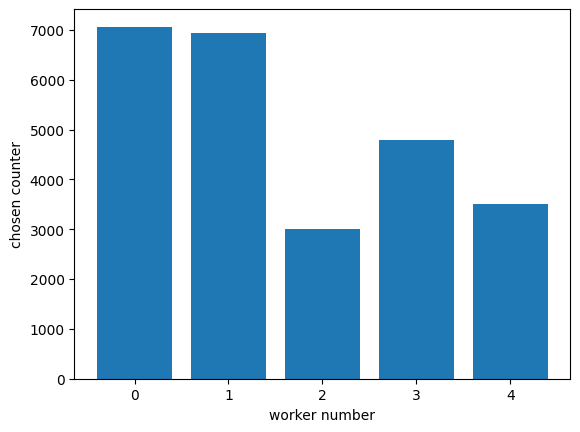

Epoch [161/200] Batch 0/157                     Loss D: 0.6266, loss G: 0.6644, FID Score: 251.6
Epoch [161/200] Batch 100/157                     Loss D: 0.6641, loss G: 0.6907, FID Score: 259.5
Epoch [162/200] Batch 0/157                     Loss D: 0.6915, loss G: 0.6112, FID Score: 260.1
Epoch [162/200] Batch 100/157                     Loss D: 0.6772, loss G: 0.6960, FID Score: 250.4
Epoch [163/200] Batch 0/157                     Loss D: 0.6622, loss G: 0.5868, FID Score: 261.6
Epoch [163/200] Batch 100/157                     Loss D: 0.6588, loss G: 0.6790, FID Score: 262.9
Epoch [164/200] Batch 0/157                     Loss D: 0.6761, loss G: 0.6448, FID Score: 249.9
Epoch [164/200] Batch 100/157                     Loss D: 0.7077, loss G: 0.6510, FID Score: 288.1
Epoch [165/200] Batch 0/157                     Loss D: 0.6907, loss G: 0.7765, FID Score: 274.9
Epoch [165/200] Batch 100/157                     Loss D: 0.6851, loss G: 0.6033, FID Score: 280.2


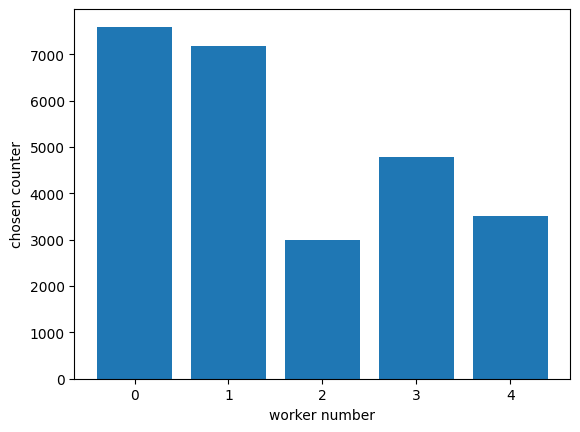

Epoch [166/200] Batch 0/157                     Loss D: 0.6914, loss G: 0.6279, FID Score: 275.3
Epoch [166/200] Batch 100/157                     Loss D: 0.6065, loss G: 0.7138, FID Score: 277.5
Epoch [167/200] Batch 0/157                     Loss D: 0.6597, loss G: 0.6513, FID Score: 289.7
Epoch [167/200] Batch 100/157                     Loss D: 0.7513, loss G: 0.5539, FID Score: 271.5
Epoch [168/200] Batch 0/157                     Loss D: 0.5802, loss G: 0.8586, FID Score: 349.3
Epoch [168/200] Batch 100/157                     Loss D: 0.6337, loss G: 0.7743, FID Score: 321.0
Epoch [169/200] Batch 0/157                     Loss D: 0.5980, loss G: 0.6840, FID Score: 292.8
Epoch [169/200] Batch 100/157                     Loss D: 0.7006, loss G: 0.5478, FID Score: 271.8
Epoch [170/200] Batch 0/157                     Loss D: 0.9909, loss G: 0.6371, FID Score: 260.9
Epoch [170/200] Batch 100/157                     Loss D: 0.6040, loss G: 0.7124, FID Score: 247.8


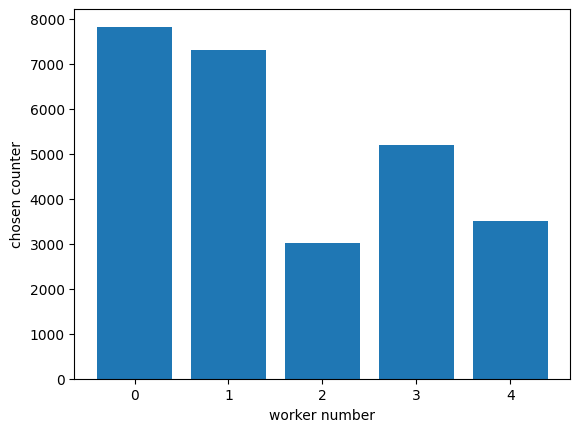

Epoch [171/200] Batch 0/157                     Loss D: 0.6219, loss G: 0.5768, FID Score: 271.2
Epoch [171/200] Batch 100/157                     Loss D: 0.6106, loss G: 0.7512, FID Score: 263.5
Epoch [172/200] Batch 0/157                     Loss D: 0.6711, loss G: 0.6911, FID Score: 250.5
Epoch [172/200] Batch 100/157                     Loss D: 0.6683, loss G: 0.6941, FID Score: 271.7
Epoch [173/200] Batch 0/157                     Loss D: 0.6338, loss G: 0.6439, FID Score: 256.7
Epoch [173/200] Batch 100/157                     Loss D: 0.6397, loss G: 0.6942, FID Score: 263.1
Epoch [174/200] Batch 0/157                     Loss D: 0.6338, loss G: 0.6395, FID Score: 264.2
Epoch [174/200] Batch 100/157                     Loss D: 0.6322, loss G: 0.7310, FID Score: 267.6
Epoch [175/200] Batch 0/157                     Loss D: 0.5865, loss G: 0.7293, FID Score: 279.9
Epoch [175/200] Batch 100/157                     Loss D: 0.6390, loss G: 0.6457, FID Score: 255.4


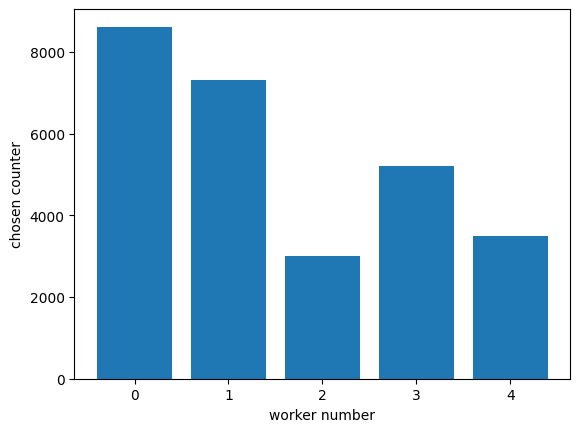

Epoch [176/200] Batch 0/157                     Loss D: 0.6644, loss G: 0.5606, FID Score: 268.7
Epoch [176/200] Batch 100/157                     Loss D: 0.6472, loss G: 0.6881, FID Score: 248.6
Epoch [177/200] Batch 0/157                     Loss D: 0.6202, loss G: 0.6793, FID Score: 256.5
Epoch [177/200] Batch 100/157                     Loss D: 0.6477, loss G: 0.7479, FID Score: 252.1
Epoch [178/200] Batch 0/157                     Loss D: 0.6210, loss G: 0.7545, FID Score: 254.7
Epoch [178/200] Batch 100/157                     Loss D: 0.6223, loss G: 0.8299, FID Score: 257.3
Epoch [179/200] Batch 0/157                     Loss D: 0.6494, loss G: 0.6546, FID Score: 271.7
Epoch [179/200] Batch 100/157                     Loss D: 0.7756, loss G: 0.6648, FID Score: 288.3
Epoch [180/200] Batch 0/157                     Loss D: 0.7170, loss G: 0.7023, FID Score: 251.5
Epoch [180/200] Batch 100/157                     Loss D: 0.6870, loss G: 0.6465, FID Score: 276.2


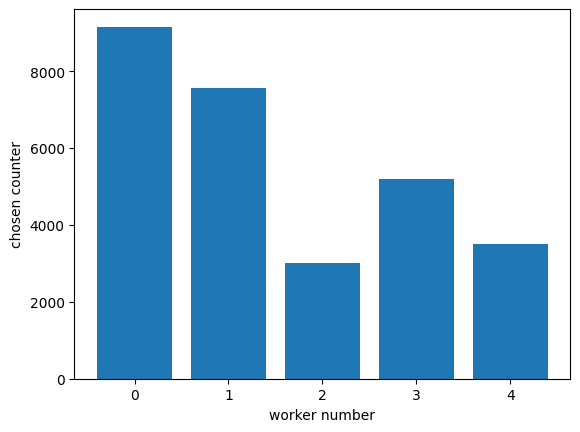

Epoch [181/200] Batch 0/157                     Loss D: 0.6976, loss G: 0.7593, FID Score: 308.4
Epoch [181/200] Batch 100/157                     Loss D: 0.6993, loss G: 0.6517, FID Score: 279.9
Epoch [182/200] Batch 0/157                     Loss D: 0.6973, loss G: 0.6643, FID Score: 272.2
Epoch [182/200] Batch 100/157                     Loss D: 0.6950, loss G: 0.6666, FID Score: 296.1
Epoch [183/200] Batch 0/157                     Loss D: 0.7165, loss G: 0.7321, FID Score: 324.7
Epoch [183/200] Batch 100/157                     Loss D: 0.6330, loss G: 0.6384, FID Score: 282.9
Epoch [184/200] Batch 0/157                     Loss D: 0.6144, loss G: 0.6967, FID Score: 343.1
Epoch [184/200] Batch 100/157                     Loss D: 0.6174, loss G: 0.6959, FID Score: 264.3
Epoch [185/200] Batch 0/157                     Loss D: 0.6552, loss G: 0.7660, FID Score: 278.6
Epoch [185/200] Batch 100/157                     Loss D: 0.6885, loss G: 0.6134, FID Score: 269.4


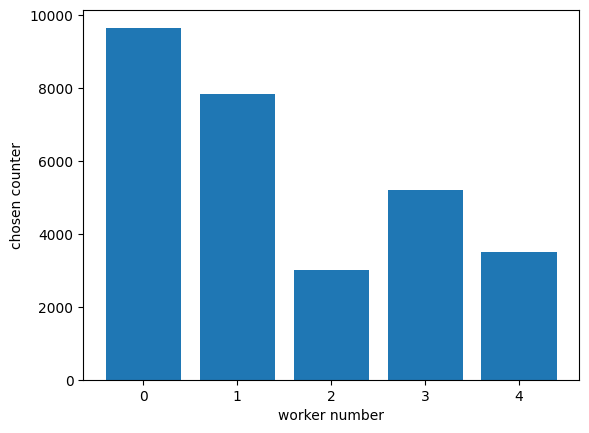

Epoch [186/200] Batch 0/157                     Loss D: 0.6071, loss G: 0.6787, FID Score: 260.6
Epoch [186/200] Batch 100/157                     Loss D: 0.5739, loss G: 0.7918, FID Score: 253.9
Epoch [187/200] Batch 0/157                     Loss D: 0.5795, loss G: 0.7396, FID Score: 260.1
Epoch [187/200] Batch 100/157                     Loss D: 0.6531, loss G: 0.7485, FID Score: 285.1
Epoch [188/200] Batch 0/157                     Loss D: 0.6727, loss G: 0.5353, FID Score: 266.4
Epoch [188/200] Batch 100/157                     Loss D: 0.6015, loss G: 0.6923, FID Score: 253.4
Epoch [189/200] Batch 0/157                     Loss D: 0.6370, loss G: 0.6389, FID Score: 265.0
Epoch [189/200] Batch 100/157                     Loss D: 0.6678, loss G: 0.8111, FID Score: 252.3
Epoch [190/200] Batch 0/157                     Loss D: 0.6884, loss G: 0.5997, FID Score: 249.2
Epoch [190/200] Batch 100/157                     Loss D: 0.6109, loss G: 0.6891, FID Score: 257.2


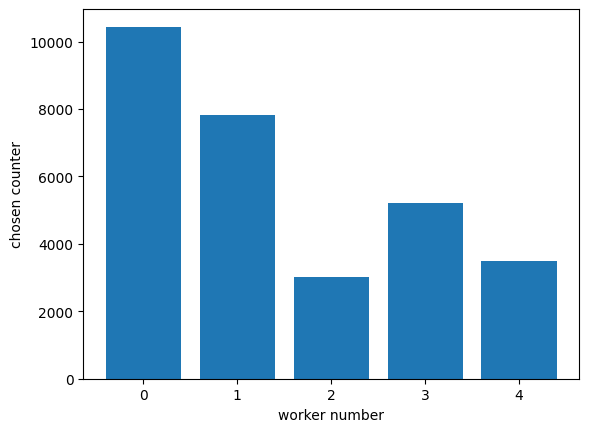

Epoch [191/200] Batch 0/157                     Loss D: 0.6470, loss G: 0.7210, FID Score: 259.8
Epoch [191/200] Batch 100/157                     Loss D: 0.6219, loss G: 0.6500, FID Score: 264.5
Epoch [192/200] Batch 0/157                     Loss D: 0.6535, loss G: 0.5895, FID Score: 266.9
Epoch [192/200] Batch 100/157                     Loss D: 0.5927, loss G: 0.8183, FID Score: 252.4
Epoch [193/200] Batch 0/157                     Loss D: 1.1293, loss G: 0.5352, FID Score: 275.0
Epoch [193/200] Batch 100/157                     Loss D: 0.6611, loss G: 0.5993, FID Score: 268.3
Epoch [194/200] Batch 0/157                     Loss D: 0.6293, loss G: 0.6481, FID Score: 255.3
Epoch [194/200] Batch 100/157                     Loss D: 0.6951, loss G: 0.6810, FID Score: 284.4
Epoch [195/200] Batch 0/157                     Loss D: 0.6658, loss G: 0.6827, FID Score: 301.2
Epoch [195/200] Batch 100/157                     Loss D: 1.2133, loss G: 0.6123, FID Score: 348.6


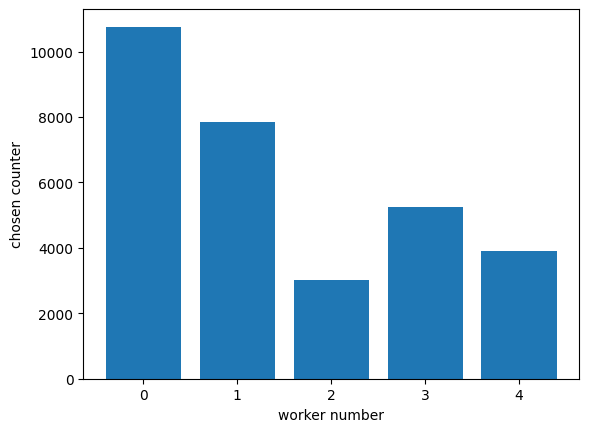

Epoch [196/200] Batch 0/157                     Loss D: 0.7082, loss G: 2.1320, FID Score: 295.9
Epoch [196/200] Batch 100/157                     Loss D: 0.5451, loss G: 0.7521, FID Score: 319.6
Epoch [197/200] Batch 0/157                     Loss D: 0.7033, loss G: 0.6241, FID Score: 260.2
Epoch [197/200] Batch 100/157                     Loss D: 0.7002, loss G: 0.6128, FID Score: 308.9
Epoch [198/200] Batch 0/157                     Loss D: 0.6280, loss G: 0.6407, FID Score: 272.5
Epoch [198/200] Batch 100/157                     Loss D: 0.7347, loss G: 0.8551, FID Score: 273.6
Epoch [199/200] Batch 0/157                     Loss D: 0.6193, loss G: 0.8615, FID Score: 280.8
Epoch [199/200] Batch 100/157                     Loss D: 0.6632, loss G: 0.6624, FID Score: 329.0


In [21]:
# main training loop for F2U (trial == FALSE)
if not trial:
    start = 0
    end = start + NUM_EPOCHS

    worker_chosen_counter = [0 for i in range(len(workers))]

    for epoch in range(start,end):
        for batch_id in range(len(worker_loaders[0])):

            highest_loss = 0
            chosen_discriminator = None
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)

            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)
                # print(real.shape)

                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                worker.discriminator.zero_grad()
                worker.loss_disc.backward()
                worker.d_optimizer.step()
                # print(worker.loss_disc_fake, i)
                if highest_loss < worker.loss_disc_fake:
                    highest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
            chosen_worker = workers[chosen_discriminator]
            worker_chosen_counter[chosen_discriminator]+=1
            

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = chosen_worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()
            main_server.g_optimizer.step()

            logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))

            # Print loss
            if batch_id % 100 == 0:
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                    Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )
            
        with torch.no_grad():
            fake = main_server.generator(fixed_noise)
            logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

        if epoch % 5 == 0 and epoch != 0:
            plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
            plt.xlabel('worker number')
            plt.ylabel('chosen counter')
            plt.show()
        if epoch % 20 == 0 and epoch != 0:
            logger.save_models(main_server,workers,epoch)